In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab
from random import randint

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
#https://github.com/smajida/mnist-fun/blob/master/keras_model.py
def add_gaussian_noise(digit, mean, stddev):
    ''' 
    This function adds gaussian noise to the matrix representations
    of the mnist digit
    IN:   
        (1) np array: the MNIST digit representations (n, 784)
        (2) float: the mean of the Gaussian to sample noise from
        (3) float: the standard deviation of the Gaussian to sample
            noise from. Note that the range of pixel values is
            0-255; 
    OUT: 
        (1) np array: noisy training data (n, 784)
    '''
    # #of images (55500 for mnist)
    n_imgs = digit.shape[0]
    # matrix size (784 for mnist)
    n_size = digit.shape[1]
    if stddev == 0:
        noise = np.zeros((n_imgs, n_size))
    else:
        # sample from normal dist
        noise = np.random.normal(mean, stddev/255.,(n_imgs, n_size))
    # add the noise to the data
    x_noisy = digit + noise
    # make sure all data points are in interval [0, 1]
    x_noisy = np.clip(x_noisy, 0., 1.)
    return x_noisy

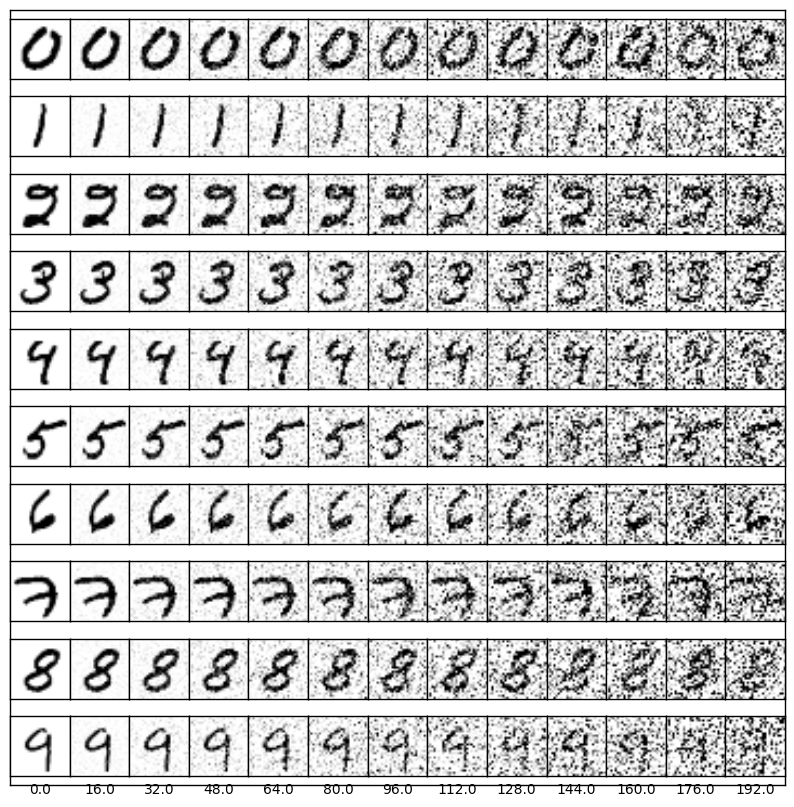

In [579]:
def show_all_noisy_digits(noise_stddevs, x_digit, y_label):
    ''' 
    IN:  
        (1) 1D numpy array: standard deviations of the Gaussian noise to add
            to example images from the X training data. Note that the image
            data has not yet been scaled from 0 to 1, but still has values
            between 0 and 255. Hardcoded to work with the len of this array
            at 97 (the total number of models trained) such that taking 
            every 8th element results in 13 examples (which is the hardcoded
            number of columns for this function)
        (2) (784, ) np array: the MNIST digit representation
        (3) 1D numpy array: y training data: the first instance of each digit
            will be taken from these labels so that an example of each
            digit can be shown
            EXAMPLE: [0,0,1,0,0,0,0,0,0,0] = the digit 2
    OUT: Plots
    
    This function displays an example of each digit from the X training data
    with increasing levels of Gaussian noise on top of it. The function is 
    hardcoded such that 13 examples of increasing noise will be shown. 
    '''
    fig = plt.figure(figsize=(10,10))
    outer_grid = gridspec.GridSpec(10, 13, wspace=0.0, hspace=0.0)
    pylab.xticks([])
    pylab.yticks([])
    
    # more efficient
    first_ind_of_each_num = {}
    for i in range(10):
        counter = 0
        # by inspection: this is enough
        while counter < 100: #len(mnist.test.labels):
            position = np.where(y_label[counter] == 1)[0][0]
            if position not in first_ind_of_each_num:
                first_ind_of_each_num[position] = counter
            counter +=1
    
    for col_ind, noise_stddev in zip(range(13), noise_stddevs[::8]):  
        x_digit_noisy = add_gaussian_noise(x_digit, 0, noise_stddev)
        
        for row_ind in range(10):
            ind_to_plot = col_ind + row_ind * 13
            ax = plt.Subplot(fig, outer_grid[ind_to_plot])
            first_ind_of_this_num = first_ind_of_each_num[row_ind]
            ax.imshow(x_digit_noisy[first_ind_of_this_num].reshape((28,28)), 
                      cmap=plt.cm.Greys)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
            if ax.is_last_row():
                ax.set_xlabel('{}'.format(noise_stddev))
            plt.subplots_adjust(wspace=0.0,hspace=0.0)
            
    # plt customization here.
    plt.show()
    
show_all_noisy_digits(noise_stddevs, digits, labels)

In [6]:
# create the stddeviations also used for the function above
# I just don't want to run the show_all_noisy_x_example function 
# every time. If you want to reuse it, put it after the stdevs= line
noise_stddevs = np.linspace(0, 192, 97)
digits, labels = mnist.train.images[:], mnist.train.labels[:]
test_digits, test_labels = mnist.test.images[:], mnist.test.labels[:]
# pick the 16, 32 ....
stddevs = noise_stddevs[::8]

In [7]:
# visualization 
# http://tneal.org/post/tensorflow-ipython/TensorFlowMNIST/
# A red/black/blue colormap
# Activation of weights
cdict = {'red':   [(0.0,  1.0, 1.0),
                    (0.25,  1.0, 1.0),
                    (0.5,  0.0, 0.0),
                    (1.0,  0.0, 0.0)],
        'green': [(0.0,  0.0, 0.0),
                    (1.0,  0.0, 0.0)],
        'blue':  [(0.0,  0.0, 0.0),
                       (0.5,  0.0, 0.0),
                       (0.75, 1.0, 1.0),
                       (1.0,  1.0, 1.0)]}
redblue = matplotlib.colors.LinearSegmentedColormap('red_black_blue',cdict,256)

In [12]:
# THIS CELL WILL HOLD THE X_NOISY NP ARRAY
# so now we can access it by x_noisy[i]
x_noisy = np.zeros([len(stddevs), len(digits), 784])

for i in range(len(stddevs)):
    print i, stddevs[i]
    x_noisy[i] = add_gaussian_noise(digits[:], 0, stddevs[i])

0 0.0
1 16.0
2 32.0
3 48.0
4 64.0
5 80.0
6 96.0
7 112.0
8 128.0
9 144.0
10 160.0
11 176.0
12 192.0


In [16]:
x_noisy_test = np.zeros([len(stddevs), len(test_digits), 784])
for i in range(len(stddevs)):
    x_noisy_test[i] = add_gaussian_noise(test_digits[:], 0, stddevs[i])

In [19]:
def data_iterator(x, y):
    """ 
    A helper function to create batches for the training data 
    IN: 
        (1) np array: the training images
        (2) np array: the labels [0000010000]
    OUT:
        Batches to train on using iter_.next()
    """
    batch_idx = 0
    while True:
        # shuffle labels and features
        idxs = np.arange(0, len(x))
        np.random.shuffle(idxs)
        shuf_features = x[idxs]
        shuf_labels = y[idxs]
        batch_size = 100
        for batch_idx in range(0, len(x), batch_size):
            images_batch = shuf_features[batch_idx:batch_idx+batch_size]
            images_batch = images_batch.astype("float32")
            labels_batch = shuf_labels[batch_idx:batch_idx+batch_size]
            yield images_batch, labels_batch

def eval_noisy_data(noise_vals, digits, labels):
    ''' 
    This function trains the model on the respective noises
    IN:  
        (1) List: list of std deviations (stddevs)
    OUT: 
        (1) List: list of tuples (Noise, accuracy)
    '''
    accuracies = []
    for i in range(len(noise_vals)):
        # create the noisy data with the noise_vals
        # use training images 555000
        # x_noisy = add_gaussian_noise(digits[:], 0, noise_val)
        # create the iterator
        iter_ = data_iterator(x_noisy[i], labels)
        
        # MODEL HERE 
        ##
        x = tf.placeholder(tf.float32, [None, 784])
        # 10 weights to learn
        w1 = tf.Variable(tf.zeros([784, 10]))
        # 10 biases to learn
        b1 = tf.Variable(tf.zeros([10]))

        #layer 2
        w2 = tf.Variable(tf.zeros([10, 10]))
        b2 = tf.Variable(tf.zeros([10]))

        # use softmax as activation
        # other options: sigmoid, softplus
        # SINGLE LAYER
        y = tf.nn.softmax(tf.matmul(x, w1) + b1)
        # 2 LAYER
        # y1 = tf.matmul(y1, w1) + b1
        # y = tf.nn.softmax(tf.matmul(y1, w2) + b2)

        y_ = tf.placeholder(tf.float32, [None, 10])

        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
        
        # use gradient descent just because.
        train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

        init = tf.initialize_all_variables()
        sess = tf.Session()
        sess.run(init)

        # train 1000 batches of size 100 (defined in iterator function)
        for _ in range(1000):
            batch_xs, batch_ys = iter_.next()  #mnist.train.next_batch(100)
            sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        final = sess.run(accuracy, feed_dict={x: x_noisy[i], y_: labels})
        
        # append to the list
        accuracies.append((noise_vals[i], final))
        
        # weight activations
        wts = w1.eval(sess)
        # digit 0 activation
        im = wts.flatten()[0::10].reshape((28,-1))
        plt.imshow(im, cmap = redblue, clim=(-1.0, 1.0))
        plt.colorbar()
        plt.show()
        
    return accuracies

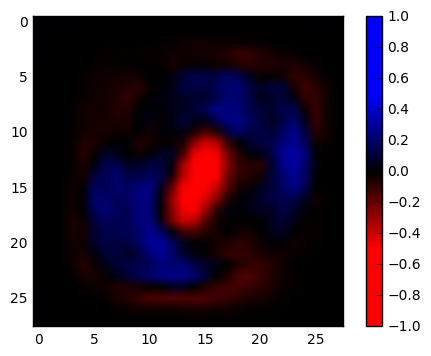

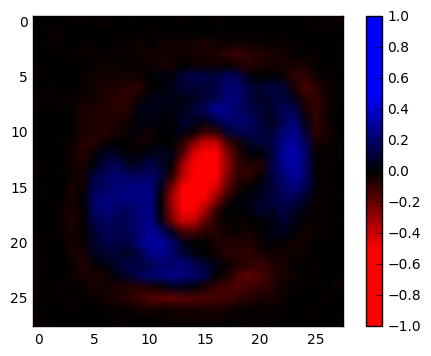

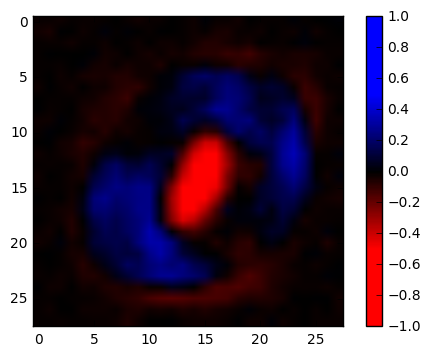

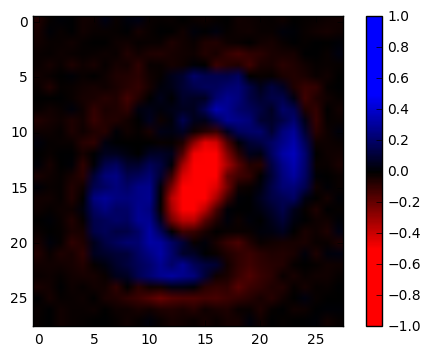

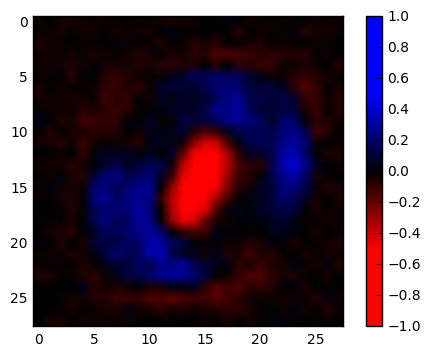

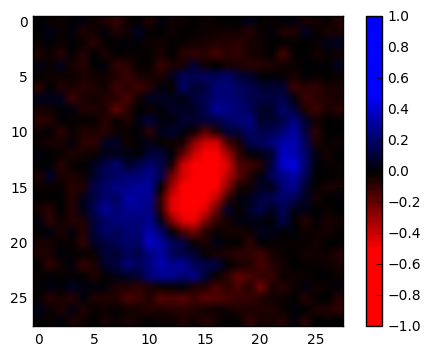

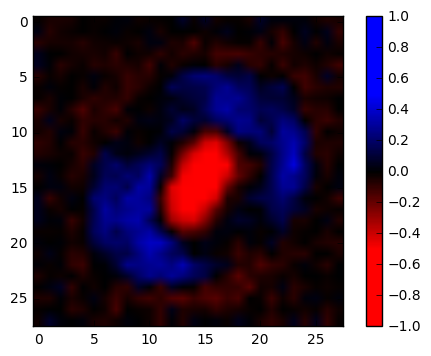

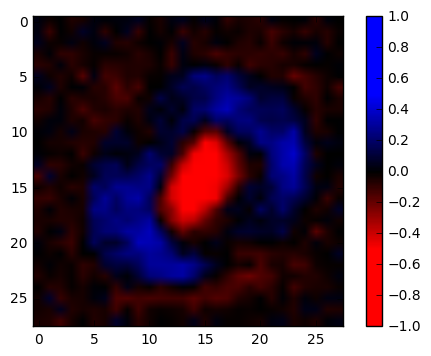

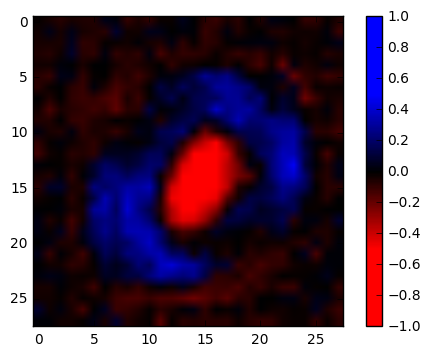

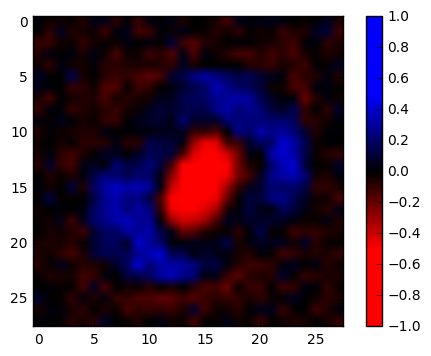

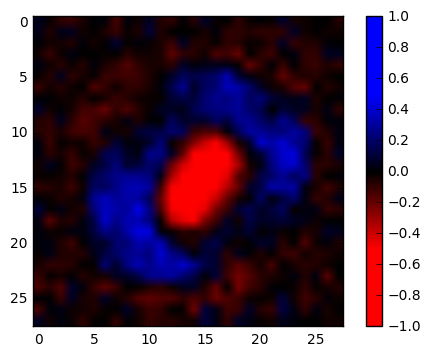

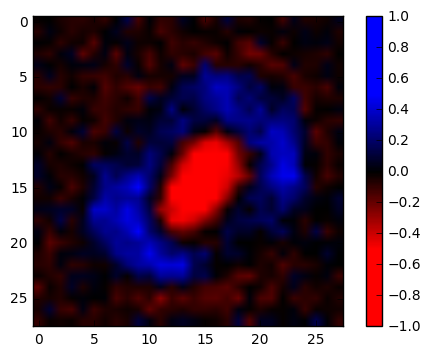

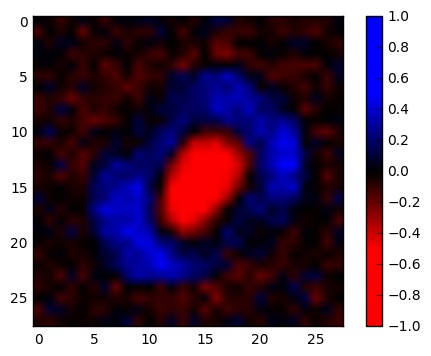

In [20]:
# get the accuracies for the noisy data.
accuracies_noisy = eval_noisy_data(stddevs, digits, labels)

[(0.0, 0.91590911), (16.0, 0.91543639), (32.0, 0.91443634), (48.0, 0.91103637), (64.0, 0.9016), (80.0, 0.89505452), (96.0, 0.88934547), (112.0, 0.87421817), (128.0, 0.85494548), (144.0, 0.76776361), (160.0, 0.81267273), (176.0, 0.75127274), (192.0, 0.70841819)]


//anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


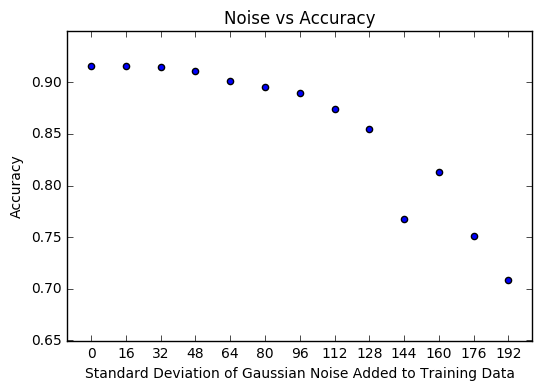

In [21]:
# make nice plot here
print accuracies_noisy
plt.title('Noise vs Accuracy')
plt.xlabel('Standard Deviation of Gaussian Noise Added to Training Data')
plt.ylabel('Accuracy')
plt.xticks(sorted(stddevs))
plt.legend(loc=3)
plt.scatter(*zip(*accuracies_noisy)) # or plot for line
plt.savefig('noise2.png')
plt.show()

In [22]:
# ZELLER AND FERGUS BLOB BASED OCCLUSION
from random import randint

#N_apply = 2.5 O (I /H + 1) + 0.5
# O = percent of occlusion [0, 1], number of times to apply the filter
# I = Imagesize (28x28)
# H = width of filter = 5% of 28 


# NO GAUSSIAN YET
def add_blob_occlusion(mnist_digits, occ_perc):
    ''' 
    This function adds occlusions to the matrix representations
    of the mnist digits
    IN:   
        (1) np array: the MNIST digit representations (n, 784)
        (2) float: percentage of occlusion after Zeiler and Fergus [0, 1]
    OUT: 
        (1) np array: occluded training data (n, 784)
        
    From Zeiler
    The blob-based occlusion algorithm involved the construction of a 
    filter that was set to 1.0 within a circle of radius 5% of the image size 
    (i.e., 5% of 144 pixels or 7 pixels) and then fell off outside   
    
    '''
    # img is 28x28 pixels
    n = 28
    n_apply = 2.5 * occ_perc * (n / (n/20.00) + 1) + 0.5
    # print "applying " + str(int(n_apply)) + " filters"
    # copy because we are going to modify them.
    occluded_digits = np.copy(mnist_digits)
    counter = 0
    for digit in occluded_digits:
        # plt.imshow(mnist_digits[counter].reshape(n,n), cmap = cm.Greys)
        # plt.show()
        # reshape to size n,n
        occluded_digit = digit.reshape(n,n)
        for i in range(int(n_apply)):
            # randint is inclusive
            # make (2, n-r)
            r = 2 # floor(28/20) = 1.4 # Zeiler 144/20 = 7.2
            a = randint(0,n)
            b = randint(0, n)
            # the coordinates
            y,x = np.ogrid[-a:n-a, -b:n-b]
            # create the circular mask
            mask = x*x + y*y <= r*r
            
            # GAUSSIAN HERE??
            # without gaussian you could potentially create new features.
            
            array = np.zeros((n, n))
            # set all values to -1 (neg numbers clipped later)
            array[mask] = -1
            # add the negative values (1-1 = 0 so the max is occluded as well)
            # could also need a gaussian fall off here
            occluded_digit = occluded_digit+array
            # make it in range 0,1 so negative numbers become 0. 
            occluded_digit = np.clip(occluded_digit, 0., 1.)
        
        # set the occluded digit in the nparray
        occluded_digits[counter] = occluded_digit.reshape(784,)
        counter+=1;
   
    return occluded_digits

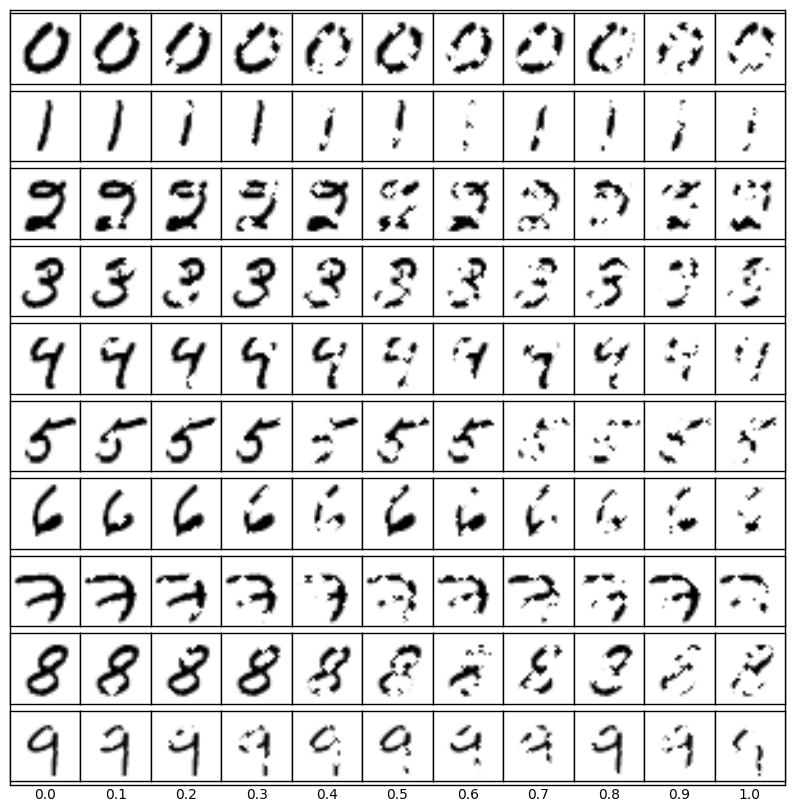

In [23]:
def show_all_occluded_digits(occ_perc, digits, label):
    ''' 
    IN:  
        (1) 1D numpy array: standard deviations of the Gaussian noise to add
            to example images from the X training data. Note that the image
            data has not yet been scaled from 0 to 1, 
        (2) (784, ) np array: the MNIST digit representation
        (3) 1D numpy array: y training data: the first instance of each digit
            will be taken from these labels so that an example of each
            digit can be shown
            EXAMPLE: [0,0,1,0,0,0,0,0,0,0] = the digit 2
    OUT: Plots
    
    This function displays an example of each digit from the X training data
    with increasing levels of occlusions of it. The function is 
    hardcoded such that 10 examples of increasing noise will be shown. 
    '''
    fig = plt.figure(figsize=(10,10))
    outer_grid = gridspec.GridSpec(10, 11, wspace=0.0, hspace=0.0)
    pylab.xticks([])
    pylab.yticks([])
    
    # more efficient
    first_ind_of_each_num = {}
    for i in range(10):
        counter = 0
        # by inspection: this is enough
        while counter < 100: #len(mnist.test.labels):
            position = np.where(labels[counter] == 1)[0][0]
            if position not in first_ind_of_each_num:
                first_ind_of_each_num[position] = counter
            counter +=1
    # loop through every occlusion percentage
    for col_ind, occ_perc in zip(range(11), occ_percs):  
        # digit_occ = add_blob_occlusion(digit, occ_perc)
        
        for row_ind in range(10):
            ind_to_plot = col_ind + row_ind * 11
            ax = plt.Subplot(fig, outer_grid[ind_to_plot])
            first_ind_of_this_num = first_ind_of_each_num[row_ind]
            digit_occ = add_blob_occlusion([digits[first_ind_of_this_num]], occ_perc)
            '''[first_ind_of_this_num]'''
            ax.imshow(digit_occ.reshape((28,28)), 
                      cmap=plt.cm.Greys)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
            if ax.is_last_row():
                ax.set_xlabel('{}'.format(occ_perc))
            plt.subplots_adjust(wspace=0.0,hspace=0.0)
    plt.show()
    
occ_percs = np.linspace(0,1,11)
show_all_occluded_digits(occ_percs, digits, labels)

In [25]:
x_occ = np.zeros([len(occ_percs), len(digits), 784])

for i in range(len(occ_percs)):
    print i, occ_percs[i]
    x_occ[i] = add_blob_occlusion(digits[:], occ_percs[i])

0 0.0
1 0.1
2 0.2
3 0.3
4 0.4
5 0.5
6 0.6
7 0.7
8 0.8
9 0.9
10 1.0


In [27]:
x_occ_test = np.zeros([len(occ_percs), len(test_digits), 784])
for i in range(len(occ_percs)):
    x_occ_test[i] = add_blob_occlusion(test_digits[:], occ_percs[i])

In [30]:
def eval_occluded_data(occ_percs, digits, labels):
    ''' 
    This function trains the model on the respective noises
    IN:  
        (1) List: list of std deviations (stddevs)
    OUT: 
        (1) List: list of tuples (Noise, accuracy)
    '''
    accuracies_occ = []
    for i in range(len(occ_percs)):
        # create the noisy data with the noise_vals
        # use training images 555000
        # x_occ = add_blob_occlusion(digits[:], occ_perc)
        # create the iterator
        iter_ = data_iterator(x_occ[i], labels)
        
        # MODEL HERE 
        ##
        x = tf.placeholder(tf.float32, [None, 784])
        # 10 weights to learn
        w1 = tf.Variable(tf.zeros([784, 10]))
        # 10 biases to learn
        b1 = tf.Variable(tf.zeros([10]))

        #layer 2
        w2 = tf.Variable(tf.zeros([10, 10]))
        b2 = tf.Variable(tf.zeros([10]))

        # use softmax as activation
        # other options: sigmoid, softplus
        # SINGLE LAYER
        y = tf.nn.softmax(tf.matmul(x, w1) + b1)
        # 2 LAYER
        # y1 = tf.matmul(y1, w1) + b1
        # y = tf.nn.softmax(tf.matmul(y1, w2) + b2)

        y_ = tf.placeholder(tf.float32, [None, 10])

        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
        
        # use gradient descent just because.
        train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

        init = tf.initialize_all_variables()
        sess = tf.Session()
        sess.run(init)

        # train 1000 batches of size 100 (defined in iterator function)
        for _ in range(1000):
            batch_xs, batch_ys = iter_.next()  #mnist.train.next_batch(100)
            sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        final = sess.run(accuracy, feed_dict={x: x_occ[i], y_: labels})
        
        # append to the list
        accuracies_occ.append((occ_percs[i], final))
        print final
        # weight activations
        wts = w1.eval(sess)
        # digit 0 activation
        im = wts.flatten()[0::10].reshape((28,-1))
        plt.imshow(im, cmap = redblue, clim=(-1.0, 1.0))
        plt.colorbar()
        plt.show()
        
    return accuracies_occ

0.916364


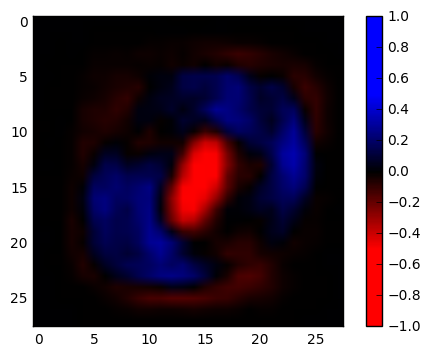

0.8934


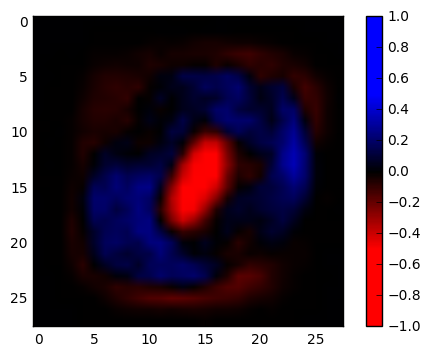

0.8652


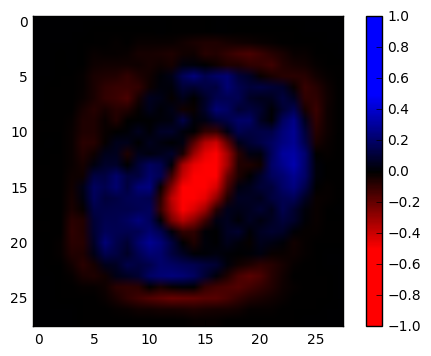

0.852618


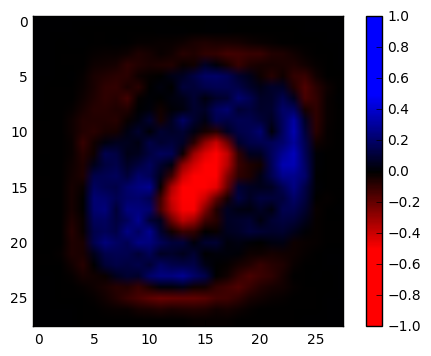

0.835709


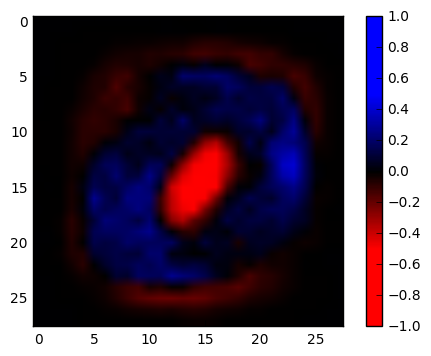

0.813745


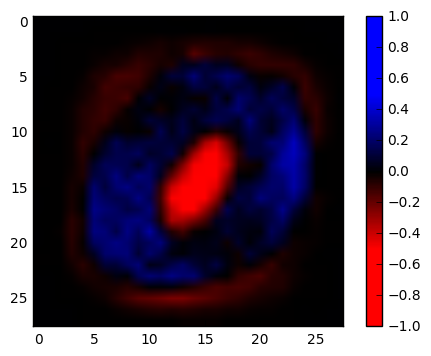

0.802436


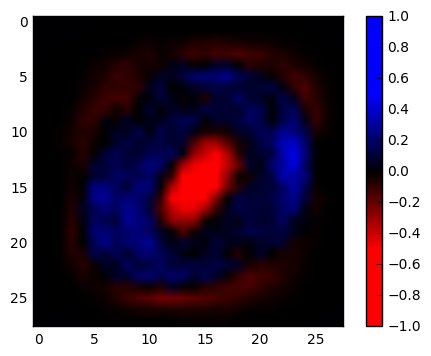

0.778436


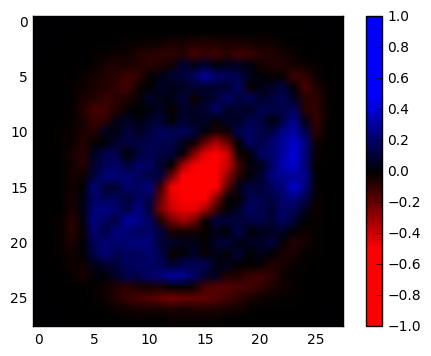

0.769273


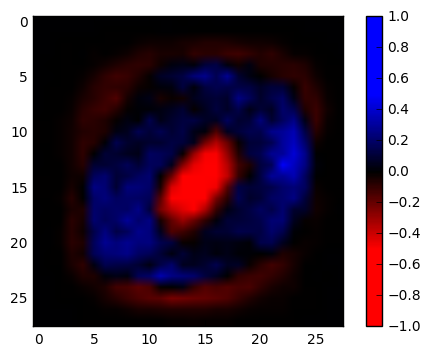

0.755364


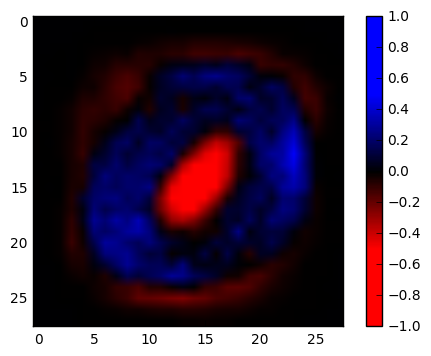

0.733636


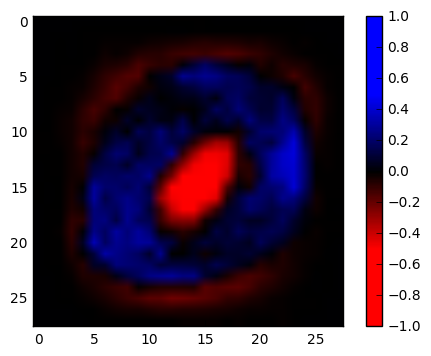

In [31]:
accuracies_occ = eval_occluded_data(occ_percs, digits, labels)

[(0.0, 0.91636366), (0.10000000000000001, 0.89340001), (0.20000000000000001, 0.86519998), (0.30000000000000004, 0.85261816), (0.40000000000000002, 0.8357091), (0.5, 0.81374544), (0.60000000000000009, 0.80243635), (0.70000000000000007, 0.77843636), (0.80000000000000004, 0.76927274), (0.90000000000000002, 0.75536364), (1.0, 0.73363638)]


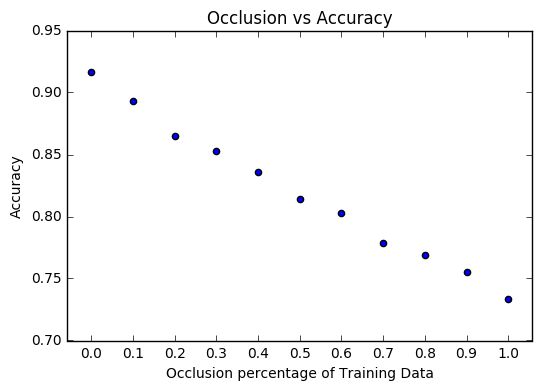

In [32]:
print accuracies_occ
plt.title('Occlusion vs Accuracy')
plt.xlabel('Occlusion percentage of Training Data')
plt.ylabel('Accuracy')
plt.xticks(sorted(occ_percs))
plt.legend(loc=3)
plt.scatter(*zip(*accuracies_occ)) # or plot for line
plt.savefig('occlusion1.png')

plt.show()

In [ ]:
# convnet performance 
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# dropout to eval performance
def eval_noisy_data_conv(noise_vals, digits, labels, dropout=True):
    ''' 
    This function trains the model on the respective noises
    IN:  
        (1) List: list of std deviations (stddevs)
    OUT: 
        (1) List: list of tuples (Noise, accuracy)
    '''
    accuracies = []
    
    for i in range(len(noise_vals)):                
        # create the noisy data with the noise_vals
        # use training images 555000
        # x_noisy = add_gaussian_noise(digits[:], 0, noise_val).astype(np.float32)
        # create the iterator
        iter_ = data_iterator(x_noisy[i].astype(np.float32), labels)

        x = tf.placeholder(tf.float32, shape=[None, 784])        
        # first conv layer
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])

        # apply layer
        x_image = tf.reshape(x, [-1,28,28,1])

        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        # do pooling
        h_pool1 = max_pool_2x2(h_conv1)

        # 64 features for 5x5 patch
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])

        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)

        # pool to 7x7 -> fully connected layer
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])

        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        
        # readout layer
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        
        # dropout
        # if dropout:
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  
        y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
        # could use adamoptimizer but then that would influence results
        train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    
        init = tf.initialize_all_variables()
        sess = tf.InteractiveSession()
        sess.run(init)

        # train 1000 batches of size 100 (defined in iterator function)
        for _ in range(100):
            batch_xs, batch_ys = iter_.next()  #mnist.train.next_batch(100)
            sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
        
        # evaluation
        correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        final = sess.run(accuracy, feed_dict={x: x_noisy[i], y_: labels, keep_prob: 1.0})
        accuracies.append((noise_val, final))
        print noise_val, final
        
    return accuracies

In [ ]:
accuracies_noisy_conv = eval_noisy_data_conv(stddevs, digits[:], labels[:], dropout=True)

In [33]:
##### AFTER KANDANS EMAIL 13-05
## 1. create priors
'''
So just take all examples of 1 , average them and that 
is the prior or expectation for digit 1. 
The priors will be used as a top down signal. The prior
image will be - some pixels in the prior image will 
be one and the other pixels will be zero. 
'''
##
# create priors of every digit
def create_priors_for_each_digit(digits, labels):
    '''
    IN: 
        (1) (784, ) np array: the MNIST digit representation
        (2) 1D numpy array: y training data
    OUT:
        (1) a (10, 784) numpy array that contains the priors(averages) of all 10 digit classes
        
    This function creates the priors. So just take all 
    examples of 1 , average them and that is the prior 
    or expectation for digit 1. 
    '''
    # 28x28, 0...9 = 10 classes
    digit_size = 784
    digit_classes = 10
    # priors[0] will contain all the 0's
    # priors[1] all the 1's etc.
    # later all the values will be averaged out by the occurence_dict
    priors = np.zeros((digit_classes, digit_size))
    
    # occurences of the digits so we can average out later.
    occurence_dict = {i: 0 for i in range(0,10)}
    
    for i in range(len(labels)):
        # digit_class is the position of the 1 in the label
        # [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.] returns 7.
        digit_class = np.where(labels[i] == 1)[0][0]
        # so (i, digit_class) = position in digits is digit digit_class
        # we have an occurence of this digit.
        occurence_dict[digit_class] += 1
        # update the value of the prior
        priors[digit_class] = np.add(priors[digit_class], digits[i])
        
    print occurence_dict
    
    # elementwise divide all the values in the priors by the #occurences of that digit
    # in this way every value will remain between 0 and 1, just as they are supposed to be   
    for i in range(priors.shape[0]):
        priors[i] = np.divide(priors[i], occurence_dict[i], where=occurence_dict[i]!=0)    
    
    return priors

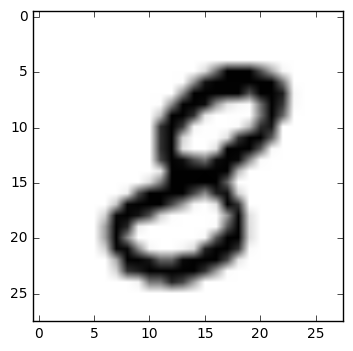

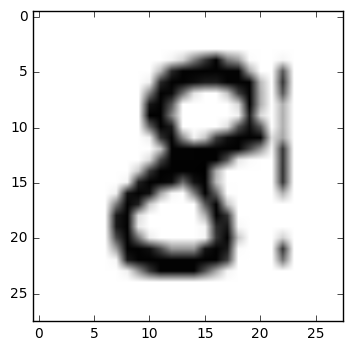

{0: 39, 1: 33, 2: 29, 3: 30, 4: 32, 5: 20, 6: 31, 7: 28, 8: 30, 9: 28}


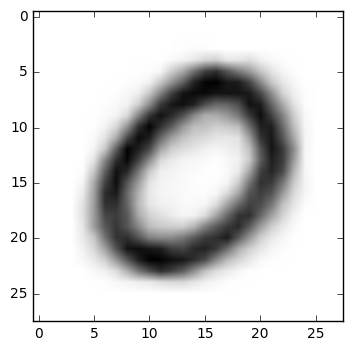

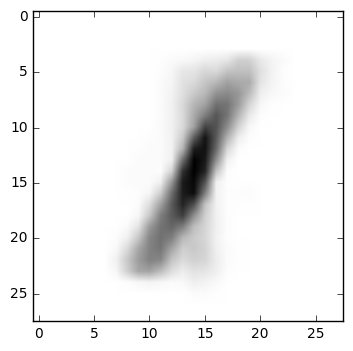

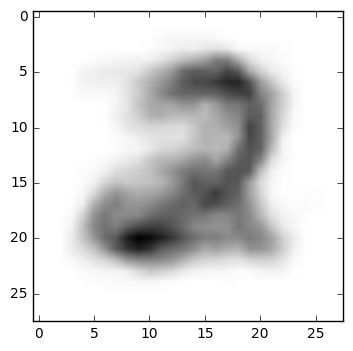

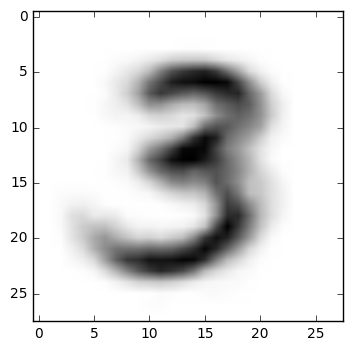

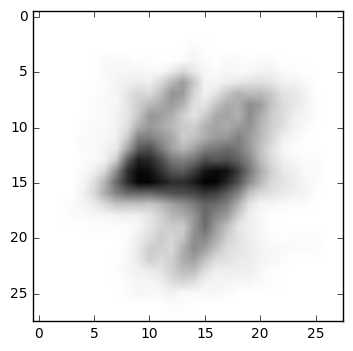

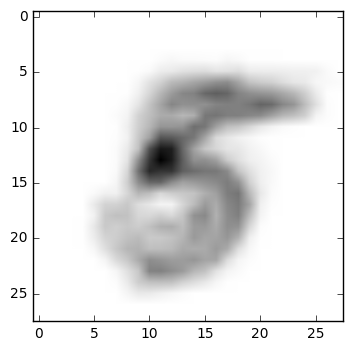

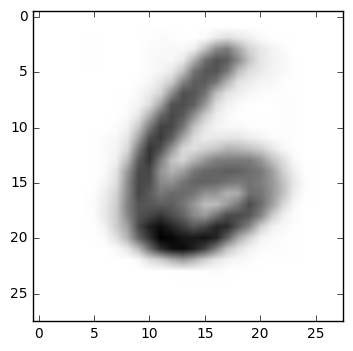

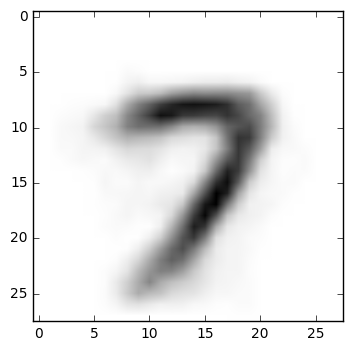

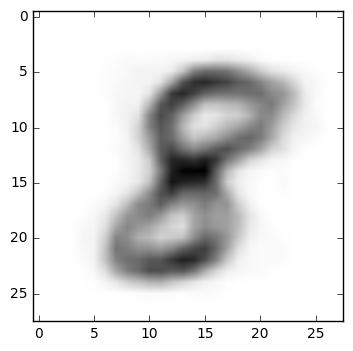

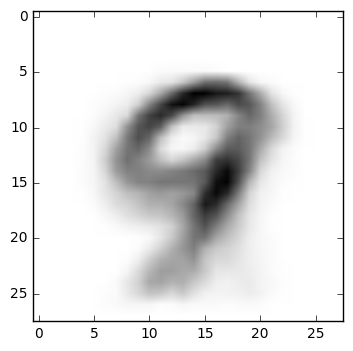

In [34]:
# here is an example of priors with two 8's
# the two 8's are in the first 10 training digits
# plot the two normal 8's 
plt.imshow(digits[:10][5].reshape((28,28)), cmap = cm.Greys)
plt.show()
plt.imshow(digits[:10][9].reshape((28,28)), cmap = cm.Greys)
plt.show()

# prior of the 8's 
# THIS IS ONLY THE PRIOR FOR THE FIRST 10 DIGITS 
# TO EFFECTIVELY SEE THE DIFFERENCES
priors_test = create_priors_for_each_digits[:300], labels[:300])

for prior in priors_test:
    plt.imshow(prior.reshape((28,28)), cmap = cm.Greys)
    plt.show()


{0: 5444, 1: 6179, 2: 5470, 3: 5638, 4: 5307, 5: 4987, 6: 5417, 7: 5715, 8: 5389, 9: 5454}


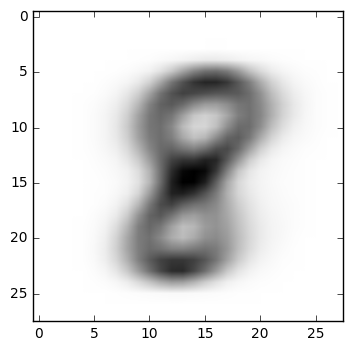

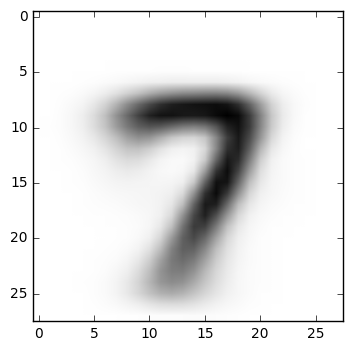

In [143]:
# training. 
priors = create_priors_for_each_digit(digits, labels)
plt.imshow(priors[8].reshape((28,28)), cmap = cm.Greys)
plt.show()

plt.imshow(priors[7].reshape((28,28)), cmap = cm.Greys)
plt.show()

# print priors[8]
# print priors[7]


In [151]:
def apply_prior(digits, labels, priors, threshold = 0):
    '''
    COMMENTS
    '''
    
    priorized_digits = np.copy(digits)
        
    for i in xrange(0, len(digits)):
        digit_class = np.where(labels[i] == 1)[0][0]

        # non-zero elements in the prior
        # select location of pixels in the prior that are not zero
        # first [] has all the pixels, [0] the value
        # print np.argwhere(priors[digit_class] > threshold)
        # idxs = priors[digit_class] > threshold
        # true means: here the prior and digit overlap
        
        zeroArray = np.zeros((784,))
        # http://stackoverflow.com/questions/25103731/numpy-change-elements-matching-conditions
    
        # np.where(condition, valuesWhereTrue, valuesWhereFalse)    
        # so here we set the values to zero that fall out of the prior, zero otherwise
        newArray = np.where(priors[digit_class] > threshold, priorized_digits[i], zeroArray)
        priorized_digits[i] = newArray
        
        return priorized_digits
    
def apply_single_prior(digit, prior, threshold):
    '''
    COMMENTS
    '''
    zeroArray = np.zeros((784,))
    # http://stackoverflow.com/questions/25103731/numpy-change-elements-matching-conditions
    # np.where(condition, valuesWhereTrue, valuesWhereFalse)    
    # so here we set the values to zero that fall out of the prior, zero otherwise
    return np.where(prior > threshold, digit, zeroArray)
    
             
# priors are done with test
var1 = apply_prior([digits[1]], [labels[1]], priors, 0.0)
plt.imshow(var1.reshape((28,28)), cmap = cm.Greys)
plt.show()
# less pixels in the digit now with threshold 0.3
var2 = apply_prior([digits[1]], [labels[1]], priors, 0.3)
plt.imshow(var2.reshape((28,28)), cmap = cm.Greys)
plt.show()
# even less if we increase the threshold
var3 = apply_prior([digits[1]], [labels[1]], priors, 0.5)
plt.imshow(var3.reshape((28,28)), cmap = cm.Greys)
plt.show()

# let's try a noisy example
# 0 least 12 most noisy

# so we pick the same # digit 1 but from the 9th noisiest range
var4 = apply_prior([x_noisy[9][1]], [labels[1]], priors, 0.0)
plt.imshow(var4.reshape((28,28)), cmap = cm.Greys)
plt.show()

var5 = apply_prior([x_noisy[9][1]], [labels[1]], priors, 0.2)
plt.imshow(var5.reshape((28,28)), cmap = cm.Greys)
plt.show()

var6 = apply_prior([x_noisy[9][1]], [labels[1]], priors, 0.4)
plt.imshow(var6.reshape((28,28)), cmap = cm.Greys)
plt.show()

# single prior -> we know which prior to apply
# should be the same digit as above.
var7 = apply_single_prior(0.4, [x_noisy[9][1]], priors[3])
plt.imshow(var7.reshape((28,28)), cmap = cm.Greys)
plt.show()

# so if we apply the prior of 4 to a 3 we expect parts of the 3 digit looking like a 4
# it will probably pick the wrong noise / digit areas
var8 = apply_single_prior(0.4, [x_noisy[9][1]], priors[4])
plt.imshow(var8.reshape((28,28)), cmap = cm.Greys)
plt.show()


SyntaxError: non-default argument follows default argument (<ipython-input-151-395d6247693f>, line 28)

In [ ]:
# used to sort the tuples
from operator import itemgetter

def eval_noisy_data_prior(threshold, noise_vals, digits, labels, apply_one=True):
    ''' 
    This function trains the model on the respective noises
    IN:  
        (1) List: list of std deviations (stddevs)
        (2) Digits: just like before
        (3) Labels: just like before
    OUT: 
        (1) List: list of tuples (Noise, accuracy)
    '''
    accuracies = []
    for i in range(len(noise_vals)):
        # create the noisy data with the noise_vals
        # use training images 555000
        # x_noisy = add_gaussian_noise(digits[:], 0, noise_val)
                
        # create the iterator
        iter_ = data_iterator(digits, labels)
        
        # MODEL HERE 
        ##
        x = tf.placeholder(tf.float32, [None, 784])
        # 10 weights to learn
        w1 = tf.Variable(tf.zeros([784, 10]))
        # 10 biases to learn
        b1 = tf.Variable(tf.zeros([10]))

        #layer 2
        w2 = tf.Variable(tf.zeros([10, 10]))
        b2 = tf.Variable(tf.zeros([10]))

        # use softmax as activation
        # other options: sigmoid, softplus
        # SINGLE LAYER
        y = tf.nn.softmax(tf.matmul(x, w1) + b1)
        # 2 LAYER
        # y1 = tf.matmul(y1, w1) + b1
        # y = tf.nn.softmax(tf.matmul(y1, w2) + b2)

        y_ = tf.placeholder(tf.float32, [None, 10])
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
        
        # use gradient descent just because.
        train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

        init = tf.initialize_all_variables()
        sess = tf.Session()
        sess.run(init)
        
        ####
        # train 1000 batches of size 100 (defined in iterator function)
        for _ in range(1000):
            batch_xs, batch_ys = iter_.next()  #mnist.train.next_batch(100)
            sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
        
        # these are the highest probabilities of the noisy images
        # these are evaluated on the network trained on normal images
        predictions = sess.run(y, feed_dict={x: x_noisy[i]})
        
        # so now we are going to run through the predictions one by one
        # and then apply priors to the respective first three guesses
        # [7 9 8] highest prob -> apply prior 7 to the digit, then 9 then 8
        # pick the one with the highest resulting probability
        
        # len(x_noisy) == len(predictions)
        y_prior = np.zeros([len(x_noisy[:10])])
        for i in range(len(x_noisy[:10])):
            # so predictions[i] == predictions on x_noisy[i]
            # loop through the 3 top predictions (predictions[i]) on x_noisy[i] here          
            acc_after_priors = []
            print predictions[i]
            for top_three_pred in (-predictions[i]).argsort()[:3].tolist():                
                # apply prior of the respective prediction
                # predictions are [8 3 7]
                # so we apply the priors 8, 3 and 7 on the digit 
                # and evaluate

                # apply the prior
                new_digit = apply_single_prior(threshold, x_noisy[i], priors[top_three_pred])
                
                # evaluate score of new digit after applying prior
                updt_acc = sess.run(y[i], feed_dict={x: new_digit})
                
                # this is the new prediction for that digit: confidence?
                print top_three_pred, updt_acc
                
                # add to list
                acc_after_priors.append((top_three_pred, updt_acc[top_three_pred]))

            # revalue highest prediction for each of the predictions
            # reverse because we need descending order
            sorted_accs = sorted(acc_after_priors,key=itemgetter(1), reverse=True)
            print sorted_accs
            # this would be the highest prediction
            print sorted_accs[0][0]
            # set this as our classification in x_after_prior
            y_prior[i] = sorted_accs[0][0]

        # Apply prior to all x_noisy's 
        # this should work as a reinforcer of the allready found confidence
        if apply_one == True:
            x_after_prior = apply_prior(x_noisy[i], labels, priors, 0.0)
            predictions_after_prior = sess.run(y, feed_dict={x: x_after_prior}) 
            correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            final = sess.run(accuracy, feed_dict={x: x_after_prior, y_: labels})
        else:
            print "-> add the previous code"
            
        # append to the list
        accuracies.append((noise_vals[i], final))
        print final
        
    return accuracies

# NUMERICAL EXAMPLE:

## initial predictions for a digit:
Here the first position indicates the probability of the digit being a 0, the second of being a 1 etc.
```
[  5.31446312e-06   8.28174791e-07   2.49808148e-01   4.79014264e-03
   3.57754296e-04   1.62426397e-06   6.44590591e-06   7.35013783e-01
   4.04045591e-03   5.97557938e-03]
```
Top three predictions are 7, 2 and 9


So we apply the priors and check if the confidence chances.


The 7 in front of the prediction list means we apply the 7 prior
```
7 [  9.89082380e-08   5.06293745e-08   1.42164608e-05   1.20876848e-05
   1.45549957e-05   8.89387124e-08   1.72245862e-09   9.98329461e-01
   3.45648823e-06   1.62606640e-03]
```
So for 7 we get a pretty high confidence (99,8%) after applying the prior.


However, it still might be a 2, so we apply this prior as well.
```
2 [  4.79917726e-05   2.65589351e-05  9.24041152e-01  1.25843119e-02
   2.10321206e-03   3.69884378e-06   1.37797440e-04   3.20478268e-02
   2.07821815e-03   2.69291624e-02]
```
It is also pretty similar to a 2, we get 92 percent that it might be a 2, after we have applied the prior of 2.
It is still a bit less less confident about the 2 than a 7.


Then the 3rd choice: we apply the 9 prior filter and see that although
the probability increases, it is not very high compared to the rest of 
the choices
```
9 [  4.17613364e-06   2.43844697e-05   1.06232800e-02   4.13835078e-04
   2.73833913e-03   2.09397854e-06   2.09301015e-06   8.74718547e-01
   2.09234748e-03   1.09380811e-01]
```
so after applying the priors we get the accuracy list:
```
[(7, 9.98329461e-01), (2, 9.24041152e-01), (9, 1.09380811e-01)]
```
We sort this and find that the 7 has the highest confidence. So we predict this.


## Other prediction
Classifier confidences are 50% of 7, 43% of 2:
```
[  9.48977504e-06   2.29522266e-06   4.35459226e-01   3.43498252e-02
   6.44823594e-04   8.96277834e-06   2.05379874e-05   4.99771178e-01
   5.16357506e-03   2.45700851e-02]
``` 
Let's apply the priors:
```
7 [  2.38011459e-08   1.85446012e-07   1.11220616e-04   2.31126862e-04
   3.62382380e-05   7.75543967e-08   7.31407246e-09   9.96724308e-01
   1.62221149e-05   2.88046827e-03]
```
Wow high confidence of a 7 99,6 percent
```
2 [  5.08271223e-05   1.11595527e-05   7.71899521e-01   1.45516796e-02
   4.58104862e-03   1.29849232e-05   1.16824311e-04   1.28946438e-01
   2.54161446e-03   7.72878677e-02]
```
Applying the 2 filter: we get 77 percent, so this clears the doubt
in this case
```
3 [  2.41471844e-05   7.81904419e-06   5.68024628e-02   4.37496424e-01
   1.04652485e-03   6.83366452e-05   3.74451247e-06   4.91320819e-01
   1.93550077e-04   1.30361076e-02]
```
Might have also been a three though, after prior we still see that it is not confident enough.


Results after prior: 
```
[(7, 0.99672431), (2, 0.77189952), (3, 0.43749642)]
```
We predict 7 with pretty decent confidence, after initially we were in doubt (50% 7 vs. 43% 2) whether we should predict a 7 or a 2.



In [145]:
# priors are created with the training digits： digits
# these results will beidentical to the scores on the model without priors: 
# we don't filter anything

# threshold
accuracies_noisy_prior = eval_noisy_data_prior(0.1, stddevs[:], digits[:], labels[:])

[  3.52676989e-06   9.68327527e-07   6.82219744e-01   3.21612717e-03
   2.66841642e-04   3.18241450e-06   1.20535196e-05   3.08029562e-01
   3.25891213e-03   2.98909890e-03]
2 [ 0.03039552  0.05401468  0.16439313  0.07060189  0.06670688  0.15505278
  0.04207374  0.31878579  0.0265265   0.07144921]
7 [ 0.03731252  0.05291954  0.23517871  0.07922344  0.06923607  0.15556875
  0.05726649  0.21715902  0.02997801  0.06615748]
8 [ 0.03453969  0.05445447  0.19887857  0.08151225  0.0709735   0.14159709
  0.04882303  0.27380922  0.02698505  0.06842715]
[(7, 0.21715902), (2, 0.16439313), (8, 0.026985053)]
7
------
[  2.02615083e-05   4.42318878e-06   7.10592954e-04   9.93001580e-01
   5.06507490e-07   8.16532178e-04   1.99467429e-08   1.39834865e-05
   4.43762448e-03   9.94591392e-04]
3 [ 0.03858283  0.04351079  0.12625214  0.11738289  0.02902095  0.36599442
  0.03072327  0.12914738  0.03096685  0.08841851]
8 [ 0.03526265  0.04444863  0.14909352  0.22296663  0.02124192  0.2792567
  0.02733418  0.

KeyboardInterrupt: 

In [99]:
accuracies_noisy_prior_02 = eval_noisy_data_prior(0.2, stddevs[:], digits[:], labels[:])

0.912291
0.9164
0.914491
0.908655
0.905218
0.892909
0.891145
0.871455
0.853655
0.838891
0.811473
0.788927
0.764036


In [89]:
accuracies_noisy_prior_01 = eval_noisy_data_prior(0.1, stddevs[:], digits[:], labels[:])

0.917036
0.917236
0.912855
0.906836
0.905473
0.890345
0.884818
0.872527
0.856545
0.790582
0.777509
0.785145
0.704836


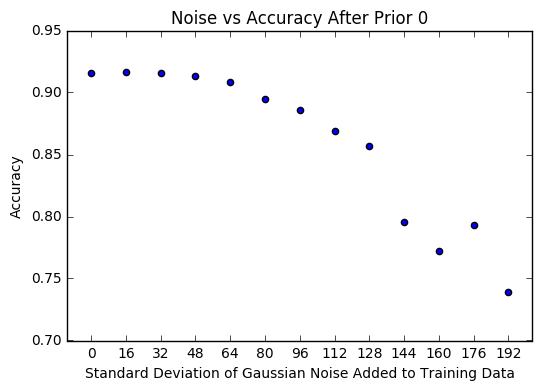

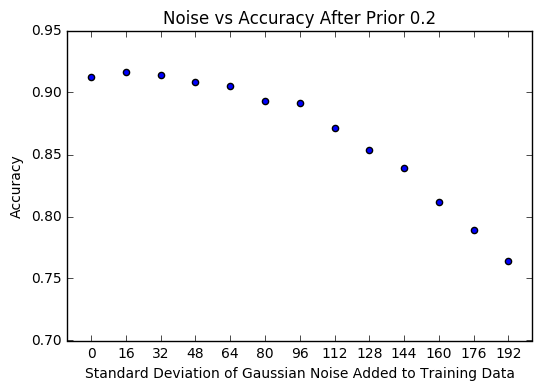

In [101]:
# THIS IS ALL AFTER THE REINFORCEMENT PRIOR

plt.title('Noise vs Accuracy After Prior 0')
plt.xlabel('Standard Deviation of Gaussian Noise Added to Training Data')
plt.ylabel('Accuracy')
plt.xticks(sorted(stddevs))
plt.legend(loc=3)
plt.scatter(*zip(*accuracies_noisy_prior)) # or plot for line
plt.savefig('noise_prior_0.png')
plt.show()
# so with 0.0 we get the same result as above.
'''
plt.title('Noise vs Accuracy After Prior 0.1')
plt.xlabel('Standard Deviation of Gaussian Noise Added to Training Data')
plt.ylabel('Accuracy')
plt.xticks(sorted(stddevs))
plt.legend(loc=3)
plt.scatter(*zip(*accuracies_noisy_prior_01)) # or plot for line
plt.savefig('noise_prior_01.png')
plt.show()'''


plt.title('Noise vs Accuracy After Prior 0.2')
plt.xlabel('Standard Deviation of Gaussian Noise Added to Training Data')
plt.ylabel('Accuracy')
plt.xticks(sorted(stddevs))
plt.legend(loc=3)
plt.scatter(*zip(*accuracies_noisy_prior_02)) # or plot for line
plt.savefig('noise_prior_02.png')
plt.show()



In [ ]:
# AFTER MEETING 21-03

# apply prior to top 3 args to pick the right one
# train on normal digits, then evaluate on after_prior
# this creates a possibility of shifting probabilities, because
# now we're assuming the first guess is the right one and 
# the one we apply the prior to (that specific class), such that
# we only reinforce this probability
# More stability allready after this method, but applying to top
# three would be better!
# 
# digit classification: relu after the first 10 input neurons
# - classify normal digits not on noise
# 
